In [91]:
import numpy as np
from qutip import *
import cvxpy as cp

import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from scipy.signal import convolve

In [109]:
# Fock space dimension
N=15

# define limit ofphase space grid
alpha_max=6

# number of grid points in one direction
ngrid = 15

# grid vectors in x- and y-direction
xvec = np.linspace(-alpha_max, alpha_max, ngrid)
yvec = xvec

### Q-function of cat state

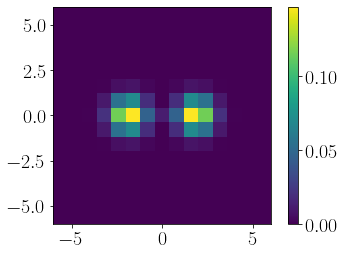

In [110]:
# size of cat
a=2

rho_cat = (coherent(N,a) + coherent(N,-a)).unit()

# plot 
q_cat = qfunc(rho_cat, xvec, xvec, g=2)
plt.imshow(q_cat, extent=[-alpha_max, alpha_max,-alpha_max, alpha_max])
plt.colorbar();

### P-function of thermal state

We will use the fact that $P^\text{th}_{n} = Q^\text{th}_{n-1}$ [1]

[1] P. Rice, [Chapter 10: Quasiprobability distributions](https://doi.org/10.1088/978-0-7503-1713-9ch10), An Introduction to Quantum Optics (2020) 

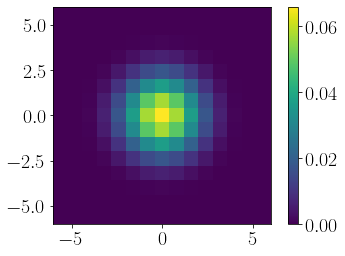

In [111]:
# mean number of thermal photons
n = 5

# note n-1 [1]
rho_thermal = thermal_dm(N, n-1)

# plot
q_thermal = qfunc(rho_thermal, xvec, xvec, g=2)
plt.imshow(q_thermal, extent=[-alpha_max, alpha_max,-alpha_max, alpha_max])
plt.colorbar();

### Convolve:
Simulate measurement of the cat state disturbed by thermal noise.

Histogram = $\int P^\text{th}_n(\alpha^* - \beta^*) Q(\beta)\, d^2\beta = \int Q^\text{th}_{n-1}(\alpha^* - \beta^*) Q(\beta)\, d^2\beta$

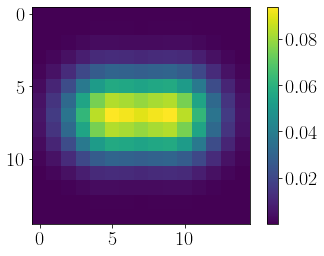

In [112]:
# convolve
q_conv = convolve(q_thermal, q_cat, mode='same')

# normalize
integral = np.trapz(np.trapz(q_conv,x=xvec), x=yvec)/np.pi
q_conv_norm = q_conv/integral

# plot
plt.imshow(q_conv_norm)
plt.colorbar()

# reshape the "noisy measurement data"
b = q_conv_norm.flatten()

### Set up measurement operators

Noise adjusted:
${\tilde \Pi^k}_n  = D(\alpha_k) \rho^\text{th}_{n} D^\dagger(\alpha_k) $

In [113]:
# Noisy measurement operator
# n is the mean number of thermal photons
def POVM_op(hilbert_size, beta, n):
        D = displace(100, beta)
        rho_h = thermal_dm(100, n)
        op = D * rho_h * D.dag()
        op = Qobj(op[:hilbert_size, :hilbert_size])
        return op

In [114]:
X, Y = np.meshgrid(xvec, xvec)
# flatten the grid of probe states into a 1D array
betas = (X + 1j*Y).ravel()

# Measurement operators
Pis = Parallel(n_jobs=16, verbose=5)(delayed(POVM_op)(N, beta,n) for beta in betas)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    3.6s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:    4.8s
[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    5.8s finished


### Construct the operator basis: 
The list `basis_dms` contains all $\Omega_k$

In [115]:
# construct vectors
basis_vectors = []
for i in range(N):
    vector = fock(N, i)
    basis_vectors.append(np.real(vector.full()))
    
# construct operators
basis_dms = []
for vector1 in basis_vectors:
    for vector2 in basis_vectors:
        dm = np.outer(vector1, vector2)
        basis_dms.append(dm)

### Construct the matrix A in $A\vec\rho=\vec b$
From `Pis` and `basis_dms`.

In [116]:
def func(index, a):
    return np.trace(Pis[index[0]].full() @ basis_dms[index[1]])

A = np.zeros((len(Pis), N*N), dtype=np.complex64)
A_p = Parallel(n_jobs=16, verbose=5, backend="multiprocessing")(delayed(func)(idx,a) for idx, a in np.ndenumerate(A))

A = np.reshape(A_p, (len(Pis), N*N))

[Parallel(n_jobs=16)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 528 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 8160 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 49858 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 50625 out of 50625 | elapsed:    1.4s finished


## Convex optimization

Define the unknown state as a $N\times N$ Hermitian matrix

In [117]:
X = cp.Variable((N,N), hermitian=True)

Set the cost function to $\|A\vec\rho - \vec b\|_2$ where the vectorized state is given by `cp.reshape(X, (N*N))`

In [118]:
cost = cp.norm(A @ cp.vec(X) - b, 2);

Set the trace constraint and positive-semidefinite constraint, respectively.

In [119]:
constraints = [cp.trace(X) == 1, X >> 0 ]

Set up and solve the problem!

In [120]:
prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(verbose=False);

# Assign the optimized state X to a Qobj.
reconstructed_rho = Qobj(X.value)

WARN: A->p (column pointers) not strictly increasing, column 346 empty
WARN: A->p (column pointers) not strictly increasing, column 362 empty
WARN: A->p (column pointers) not strictly increasing, column 378 empty
WARN: A->p (column pointers) not strictly increasing, column 394 empty
WARN: A->p (column pointers) not strictly increasing, column 410 empty
WARN: A->p (column pointers) not strictly increasing, column 426 empty
WARN: A->p (column pointers) not strictly increasing, column 442 empty
WARN: A->p (column pointers) not strictly increasing, column 458 empty
WARN: A->p (column pointers) not strictly increasing, column 474 empty
WARN: A->p (column pointers) not strictly increasing, column 490 empty
WARN: A->p (column pointers) not strictly increasing, column 506 empty
WARN: A->p (column pointers) not strictly increasing, column 522 empty
WARN: A->p (column pointers) not strictly increasing, column 538 empty
WARN: A->p (column pointers) not strictly increasing, column 554 empty
WARN: 

### Visualize results

Plot the reconstructed state and show the fidelity

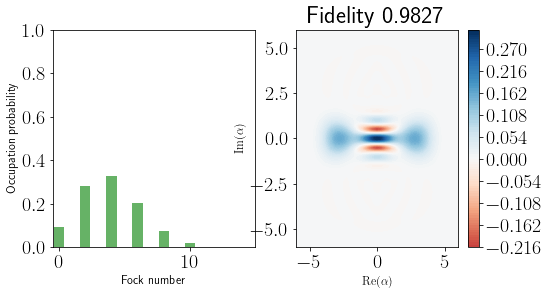

In [121]:
fig, ax = plot_wigner_fock_distribution(reconstructed_rho, alpha_max=alpha_max, colorbar=True)
plt.title("Fidelity {:.4}".format(fidelity(reconstructed_rho, rho_cat)**2));

Ideal state

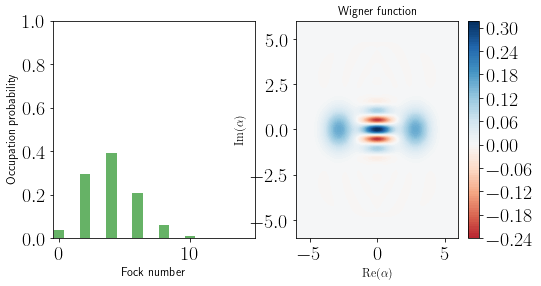

In [122]:
fig, ax = plot_wigner_fock_distribution(rho_cat, alpha_max=alpha_max, colorbar=True)